<a href="https://colab.research.google.com/github/yaraabdou/AI-Projects/blob/main/Skin_Lesion_Classification_ViT_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Lesion Classification using Vision Transformers

## Introduction

Skin cancer is a prevalent public health concern, and early detection is crucial for successful treatment. Automated skin lesion classification using deep learning models has shown immense promise in improving diagnostic accuracy and efficiency. This Colab notebook explores the application of **Vision Transformers (ViTs)**, a cutting-edge class of deep learning models, for skin lesion classification.

ViTs have gained significant attention in the field of computer vision due to their ability to capture long-range dependencies and contextual information in images. They leverage the power of **self-attention** to weigh different parts of an image based on their relevance to the classification task. This makes them particularly well-suited for complex image analysis tasks like skin lesion classification, where subtle patterns and features can be indicative of malignancy.

**In this Colab, we will:**

1. **Explore the HAM10000 dataset:** This publicly available dataset contains a large collection of dermoscopic images of skin lesions, along with their corresponding diagnoses.
2. **Implement a ViT-based classification model:** We will adapt a pre-trained ViT model, leveraging transfer learning to accelerate the training process and enhance performance.
3. **Evaluate the model's performance:** We will assess the model's accuracy using metrics like accuracy. We will also visualize the results using a confusion matrix to gain insights into the model's strengths and weaknesses.
4. **Fine-tune the model:** We will explore techniques to fine-tune the pre-trained ViT model for improved performance on the skin lesion classification task.
5. **Perform hyperparameter optimization:** We will use Keras Tuner to search for the optimal hyperparameter values, further enhancing the model's performance.
6. **Deploy a live demo:** We will create an interactive demo that allows users to upload their own images and receive predictions from the trained model.


## Usual Setup

In [ ]:
# basic python imports and packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import json

In [ ]:
# install the latest version of keras and keras-hub
!!pip install -q git+https://github.com/keras-team/keras-hub.git
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

['\x1b[?25l   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b0.0/1.3 MB\x1b \x1b?\x1b eta \x1b-:--:--\x1b',
 '\x1b[2K   \x1b━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\x1b \x1b1.3/1.3 MB\x1b \x1b58.5 MB/s\x1b eta \x1b0:00:00\x1b',
 "\x1b[?25h\x1bERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.",
 'keras-nlp 0.18.1 requires keras-hub==0.18.1, but you have keras-hub 0.20.0.dev0 which is incompatible.\x1b\x1b',
 '\x1b']

In [ ]:
# deep learning imports and packages
os.environ["KERAS_BACKEND"] = "jax"
import keras
# from keras import losses
# from keras import ops
# from keras import optimizers
# from keras.optimizers import schedules
# from keras.applications.imagenet_utils import decode_predictions
# from keras.layers import Dropout, Dense, GlobalAveragePooling1D, Flatten, Lambda
import keras_hub

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

In [ ]:
# Make sure GPU is loaded correctly
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
  print("Successfully loaded GPU!")


from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Tue Mar 11 01:11:49 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             45W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!wget -q -P ./ https://www.dropbox.com/s/tghspdad4ket7v8/archive.zip

In [ ]:
!unzip -qq archive.zip

In [ ]:
import shutil, pathlib
from sklearn.model_selection import train_test_split
base_dir = pathlib.Path("/content")

In [ ]:
base_dir = pathlib.Path("/content")
image_part1_dir = pathlib.Path("/content/HAM10000_images_part_1")
image_part2_dir = pathlib.Path("/content/HAM10000_images_part_2")
metadata_path = pathlib.Path("/content/HAM10000_metadata.csv")

In [ ]:
metadata = pd.read_csv(metadata_path)
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# New base directory for organized data
organized_data_dir = pathlib.Path("/content/data")
os.makedirs(organized_data_dir, exist_ok=True)

In [ ]:
# Get unique diagnosis categories
dx_categories = metadata['dx'].unique()

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


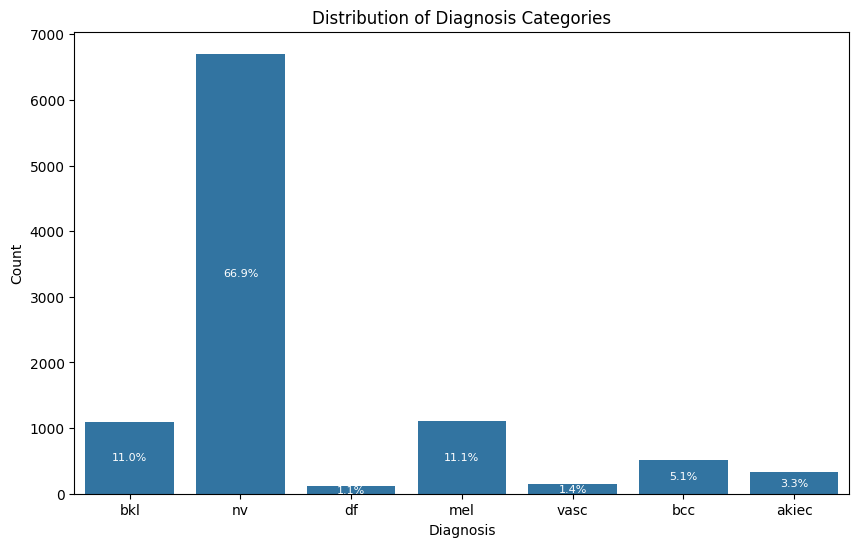

In [ ]:
# Count occurrences of each diagnosis category
dx_counts = metadata['dx'].value_counts()

# Print the distribution
print(dx_counts)

# Visualize the distribution using a bar plot
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='dx', data=metadata)
plt.title('Distribution of Diagnosis Categories')
plt.xlabel('Diagnosis')
plt.ylabel('Count')

# Add percentage labels (before plt.show())
total = len(metadata)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2  # Center the label horizontally
    y = p.get_y() + p.get_height() / 2  # Center the label vertically
    ax.annotate(percentage, (x, y), size=8, ha='center', va='center', color='white')

plt.show() # Display the plot with annotations

In [ ]:
# Group images by lesion ID
lesion_groups = metadata.groupby('lesion_id')['image_id'].apply(list).reset_index()

In [ ]:
# Split lesion IDs into train, validation, and test sets
train_lesion_ids, test_lesion_ids = train_test_split(lesion_groups['lesion_id'], test_size=0.2, random_state=42)
train_lesion_ids, val_lesion_ids = train_test_split(train_lesion_ids, test_size=0.2, random_state=42)

In [ ]:
# Iterate over lesion IDs and copy images
for data_type, lesion_ids in zip(['train', 'validation', 'test'], [train_lesion_ids, val_lesion_ids, test_lesion_ids]):
    for lesion_id in lesion_ids:
        image_filenames = lesion_groups[lesion_groups['lesion_id'] == lesion_id]['image_id'].values[0]
        dx_category = metadata[metadata['image_id'] == image_filenames[0]]['dx'].values[0]  # Get dx category for the lesion

        for fname in image_filenames:
            fname += '.jpg'
            src_path = (image_part1_dir / fname) if os.path.exists(image_part1_dir / fname) else (image_part2_dir / fname)
            dst_path = organized_data_dir / data_type / dx_category / fname
            os.makedirs(os.path.dirname(dst_path), exist_ok=True)  # Create directory if it doesn't exist
            shutil.copyfile(src=src_path, dst=dst_path)

print("Data organization completed.")

Data organization completed.


In [ ]:
train_dataset = keras.utils.image_dataset_from_directory(
    organized_data_dir / 'train',  # Path to training data directory
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'  # Set label_mode to 'categorical'
)

validation_dataset = keras.utils.image_dataset_from_directory(
    organized_data_dir / 'validation',  # Path to validation data directory
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'  # Set label_mode to 'categorical'
)

test_dataset = keras.utils.image_dataset_from_directory(
    organized_data_dir / 'test',  # Path to test data directory
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'  # Set label_mode to 'categorical'
)

Found 6402 files belonging to 7 classes.
Found 1589 files belonging to 7 classes.
Found 2024 files belonging to 7 classes.


In [ ]:
for images, _ in train_dataset.take(1):
  print(images[0].shape)

(224, 224, 3)


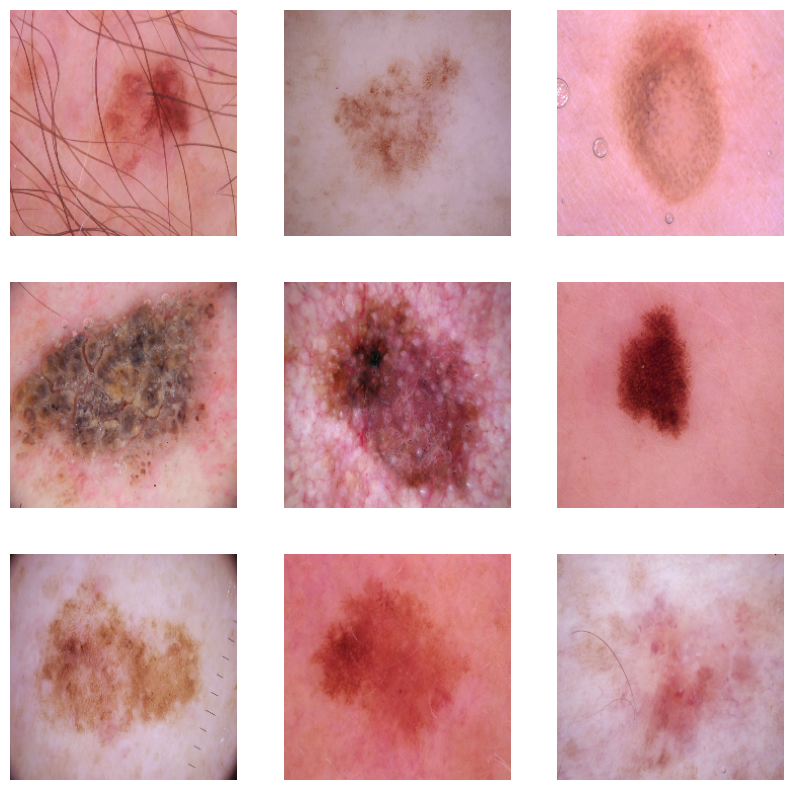

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

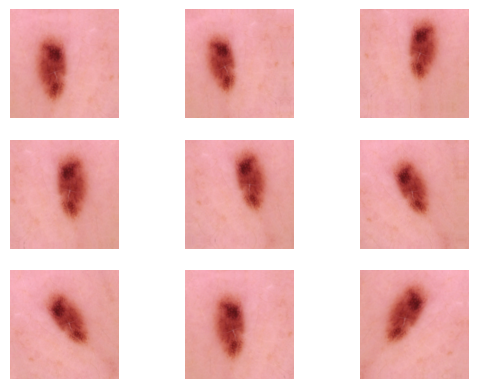

In [ ]:
def augment_data(image):
  data_augmentation = keras.Sequential([
      keras.layers.RandomFlip("horizontal"),
      keras.layers.RandomRotation(0.1),
      keras.layers.RandomZoom(0.1),
      keras.layers.RandomTranslation(0.1, 0.1),
  ])
  return data_augmentation(image)

  plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment_data(images[0])
    plt.imshow(np.array(augmented_image).astype("uint8"))
    plt.axis("off")

In [ ]:
# We download the ViT preprocessor and the backbone

preprocessor = keras_hub.models.ViTImageClassifierPreprocessor.from_preset(
    "vit_base_patch16_224_imagenet"
)

backbone = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")

100%|██████████| 593/593 [00:00<00:00, 1.15MB/s]


100%|██████████| 1.65k/1.65k [00:00<00:00, 3.14MB/s]


100%|██████████| 328M/328M [00:21<00:00, 15.9MB/s]


In [ ]:
# Define data augmentation pipeline
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

In [ ]:
inputs = keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)                             # Apply data augmentation
x = preprocessor(x)                                       # Preprocess input for ViT
x = backbone(x)[:, 0, :]                                  # Run through ViT backbone, select CLS embedding
x = keras.layers.Dense(256, activation="relu")(x)         # Run through a dense layer
outputs = keras.layers.Dense(7, activation="softmax")(x)

# Create the model
model = keras.Model(inputs, outputs)

# Summary of the model
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,997,319 (328.05 MB)

 Trainable params: 85,997,319 (328.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Freeze the backbone
backbone.trainable = False

model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,997,319 (328.05 MB)

 Trainable params: 198,663 (776.03 KB)

 Non-trainable params: 85,798,656 (327.30 MB)

In [ ]:
from keras.callbacks import EarlyStopping

# Compile the model for initial training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4)

# Train
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=7,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 117s 529ms/step - accuracy: 0.6317 - loss: 1.0994 - val_accuracy: 0.7080 - val_loss: 0.8290
Epoch 2/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 96s 476ms/step - accuracy: 0.7331 - loss: 0.7452 - val_accuracy: 0.7332 - val_loss: 0.7486
Epoch 3/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 95s 471ms/step - accuracy: 0.7600 - loss: 0.6650 - val_accuracy: 0.7483 - val_loss: 0.7100
Epoch 4/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 95s 474ms/step - accuracy: 0.7786 - loss: 0.6153 - val_accuracy: 0.7558 - val_loss: 0.6864
Epoch 5/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 97s 482ms/step - accuracy: 0.7836 - loss: 0.6023 - val_accuracy: 0.7627 - val_loss: 0.6598
Epoch 6/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 97s 480ms/step - accuracy: 0.7935 - loss: 0.5582 - val_accuracy: 0.7722 - val_loss: 0.6434
Epoch 7/7
201/201 ━━━━━━━━━━━━━━━━━━━━ 97s 481ms/step - accuracy: 0.7996 - loss: 0.5462 - val_accuracy: 0.7854 - val_loss: 0.6324


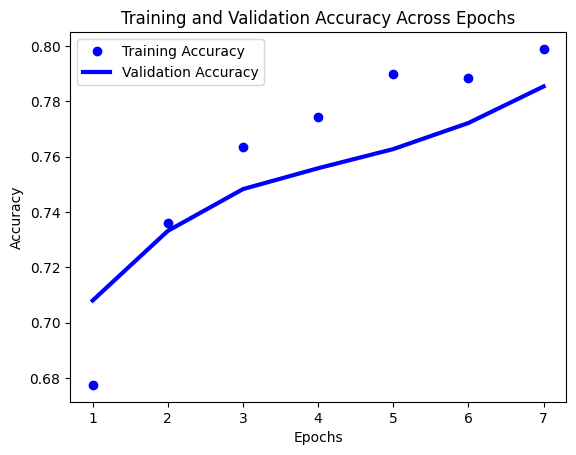

In [ ]:
def plot_accuracy(history):
    history_dict = history.history
    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training Accuracy", linewidth=3)
    plt.plot(epochs, val_acc, "b", label="Validation Accuracy", linewidth=3)
    plt.title("Training and Validation Accuracy Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_accuracy(history)

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 19s 297ms/step - accuracy: 0.7538 - loss: 0.6543
Test accuracy: 0.7589


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 522ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,bkl,nv,df,mel,vasc,bcc,akiec
bkl,13,4,29,1,2,18,0
nv,5,27,16,4,9,28,1
df,4,8,141,1,28,61,0
mel,2,1,3,2,0,10,0
vasc,6,4,22,2,89,113,0
bcc,1,4,43,4,34,1248,2
akiec,0,5,0,0,4,9,16


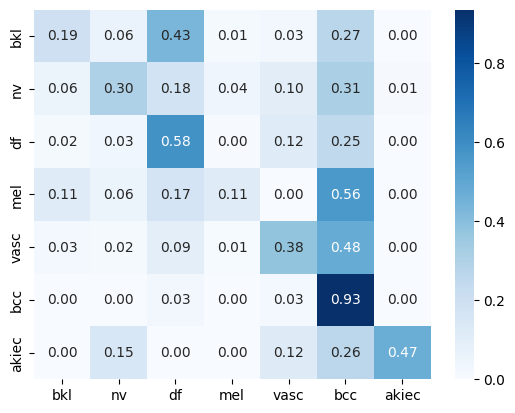

In [ ]:
from IPython.display import display

def show_confusion_matrix(model):
    """
    Calculates the test accuracy, confusion matrix and heat map for a model.
    """
    global test_dataset, dx_categories

    y_pred = []  # Collect predictions
    y_actual = []  # Collect actual labels

    for images, labels in test_dataset:
        y_pred.extend(model.predict(images).argmax(axis=1))  # Extend predictions
        y_actual.extend(labels.numpy().argmax(axis=1))  # Extend with actual labels

    print('*************************\n* Test Accuracy: %.4f *\n*************************' % metrics.accuracy_score(y_actual, y_pred))

    cm = pd.DataFrame(metrics.confusion_matrix(y_actual, y_pred), index=dx_categories, columns=dx_categories)
    display(cm)

    cm = cm.div(cm.sum(axis=1), axis=0)

    sns.heatmap(cm, cmap="Blues", annot=True, fmt=".2f")

show_confusion_matrix(model)

In [ ]:
# Model with trainable backbone
inputs = keras.layers.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)                             # Apply data augmentation
x = preprocessor(x)                                       # Preprocess input for ViT
x = backbone(x)[:, 0, :]                                  # Run through ViT backbone, select CLS embedding
x = keras.layers.Dense(256, activation="relu")(x)         # Run through a dense layer
outputs = keras.layers.Dense(7, activation="softmax")(x)

backbone.trainable = True

# Create the model
model_tb = keras.Model(inputs, outputs)

# Summary of the model
model_tb.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item_1 (GetItem)                 │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,997,319 (328.05 MB)

 Trainable params: 85,997,319 (328.05 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the model for initial training
model_tb.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=4)

# Train
history_tb = model_tb.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=30,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.7085 - loss: 0.8136 - val_accuracy: 0.8125 - val_loss: 0.5608
Epoch 2/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.8239 - loss: 0.4911 - val_accuracy: 0.7583 - val_loss: 0.6885
Epoch 3/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8511 - loss: 0.4028 - val_accuracy: 0.8225 - val_loss: 0.5777
Epoch 4/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.8985 - loss: 0.2670 - val_accuracy: 0.8238 - val_loss: 0.6334
Epoch 5/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.9164 - loss: 0.2229 - val_accuracy: 0.8206 - val_loss: 0.6007
Epoch 6/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.9390 - loss: 0.1635 - val_accuracy: 0.8131 - val_loss: 0.6426
Epoch 7/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 402s 2s/step - accuracy: 0.9421 - loss: 0.1600 - val_accuracy: 0.8351 - val_loss: 0.6472
Epoch 8/30
201/201 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.9609 - loss: 0.1081 - val_accu

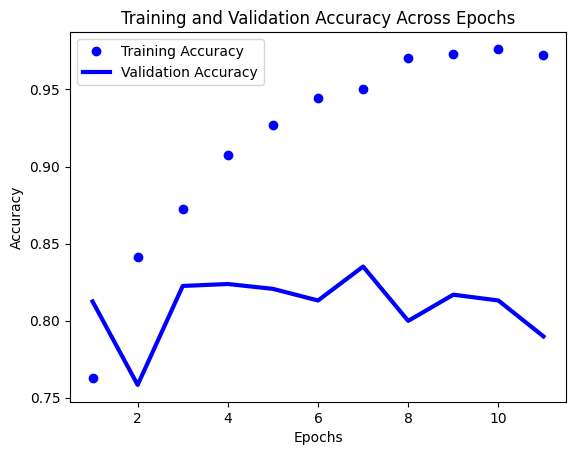

In [ ]:
def plot_accuracy(history_tb):
    history_tb_dict = history_tb.history
    acc = history_tb_dict["accuracy"]
    val_acc = history_tb_dict["val_accuracy"]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, "bo", label="Training Accuracy", linewidth=3)
    plt.plot(epochs, val_acc, "b", label="Validation Accuracy", linewidth=3)
    plt.title("Training and Validation Accuracy Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

plot_accuracy(history_tb)

In [ ]:
test_loss, test_accuracy = model_tb.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy:.4f}")

64/64 ━━━━━━━━━━━━━━━━━━━━ 16s 243ms/step - accuracy: 0.7894 - loss: 0.7881
Test accuracy: 0.7871


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

,bkl,nv,df,mel,vasc,bcc,akiec
bkl,35,2,11,0,14,5,0
nv,31,42,5,0,3,8,1
df,13,1,134,0,65,30,0
mel,9,0,0,4,2,3,0
vasc,4,0,9,0,166,57,0
bcc,1,5,24,2,113,1190,1
akiec,0,2,2,0,7,1,22


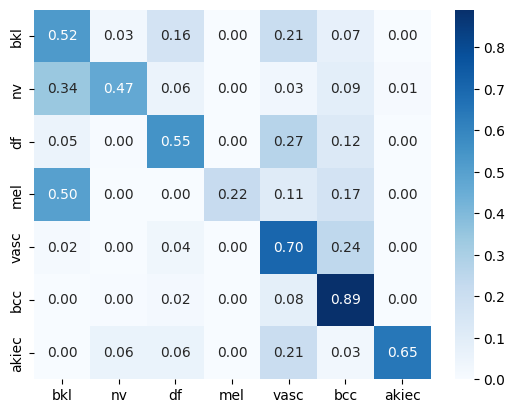

In [ ]:
show_confusion_matrix(model_tb)

# Hyperparameter Optimization

In [ ]:
!pip install keras-tuner -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.3 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
    inputs = keras.layers.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    x = preprocessor(x)
    x = backbone(x)[:, 0, :]

    # Dense layer with hp.Choice for units
    x = keras.layers.Dense(units=hp.Choice('units', values=[32, 64, 128]), activation="relu")(x)

    outputs = keras.layers.Dense(7, activation="softmax")(x)

    # Tune the backbone training strategy
    hp_backbone_strategy = hp.Choice('backbone_strategy', values=['freeze', 'finetune'])
    if hp_backbone_strategy == 'freeze':
        backbone.trainable = False
    else:
        backbone.trainable = True

    model_hp = keras.Model(inputs, outputs)

    # Tune the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    model_hp.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    return model_hp

In [ ]:
tuner = kt.GridSearch(
    build_model,               # we pass in the model-building function we created
    objective="val_accuracy",  # we tell the optimizer to find the hyperparameter with the max validation accuracy
    overwrite=True             # an annoying little technical detail - don't worry about it
)

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
units (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64, 128], 'ordered': True}
backbone_strategy (Choice)
{'default': 'freeze', 'conditions': [], 'values': ['freeze', 'finetune'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [ ]:
tuner.search(train_dataset,
             epochs=30,
             batch_size=64,
             verbose=1,
             validation_data=validation_dataset,
             callbacks=[early_stopping]
             )

Trial 18 Complete [00h 35m 56s]
val_accuracy: 0.6897419691085815

Best val_accuracy So Far: 0.8212712407112122
Total elapsed time: 10h 09m 51s


In [ ]:
best_model = tuner.get_best_models(1)[0]

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_9 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_image_classifier_preprocessor   │ (None, 224, 224, 3)         │               0 │
│ (ViTImageClassifierPreprocessor)     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vi_t_backbone (ViTBackbone)          │ (None, 197, 768)            │      85,798,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ get_item (GetItem)                   │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          24,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             231 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 85,823,495 (327.39 MB)

 Trainable params: 24,839 (97.03 KB)

 Non-trainable params: 85,798,656 (327.30 MB)

Classify New Picture - Live Demo

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def classify_image(uploaded_image):
    """Classifies the uploaded image using the pre-trained model."""
    # Read the image data from the uploaded file
    img = keras.preprocessing.image.load_img(uploaded_image, target_size=(224, 224))

    # Convert the image to a NumPy array
    img_array = keras.preprocessing.image.img_to_array(img)

    # Apply the same preprocessing as during training
    img_array = preprocessor(img_array)

    # Make a prediction using the model
    prediction = best_model.predict(np.expand_dims(img_array, axis=0))

    # Get the predicted class label and probability
    predicted_class_index = np.argmax(prediction)
    predicted_class = dx_categories[predicted_class_index]  # Get class name

    return predicted_class

# Create an image upload widget
uploader = widgets.FileUpload(
    accept='image/*',  # Accept only image files
    multiple=False     # Allow only one upload at a time
)

display(uploader)

# Add a button to trigger classification
button = widgets.Button(description="Classify")

def on_button_clicked(b):
    """Handles button click event and classifies the uploaded image."""
    uploaded_image_content = uploader.value[list(uploader.value.keys())[0]]['content']
    with open('uploaded_image.jpg', 'wb') as f:
        f.write(uploaded_image_content)
    predicted_class = classify_image('uploaded_image.jpg')

    # Display the image
    display(widgets.Image(value=uploaded_image_content))

    print(f"Predicted class: {predicted_class}")

button.on_click(on_button_clicked)

display(button)

# Create a clear button
clear_button = widgets.Button(description="Clear")

def clear_uploader(b):
    uploader.value.clear()
    uploader._counter = 0  # Reset the counter

clear_button.on_click(clear_uploader)

display(clear_button)

FileUpload(value={}, accept='image/*', description='Upload')

Button(description='Classify', style=ButtonStyle())

Button(description='Clear', style=ButtonStyle())

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


Image(value=b'\xff\xd8\xff\xdb\x00C\x00\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x01\x0…

Predicted class: bcc
